In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install cython pyyaml==5.1
!python -m pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html && \
python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 27.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=b6fe6b9d027da9c689f497261e8a471c583ad185dbddcbd94366e8d8f88d9fc8
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8 MB 21 kB/s 
     |████████████████████████████████| 6.6 MB 29.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:

In [8]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
# !pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 14392, done.
remote: Total 14392 (delta 0), reused 0 (delta 0), pack-reused 14392
Receiving objects: 100% (14392/14392), 5.89 MiB | 4.18 MiB/s, done.
Resolving deltas: 100% (10416/10416), done.


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.5 ; cuda:  cu101
detectron2: 0.3


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [29]:
!gdown 1q-ZorGs2-i49xVmpkfNCXzDaNS5oS2Qe

Downloading...
From: https://drive.google.com/uc?id=1q-ZorGs2-i49xVmpkfNCXzDaNS5oS2Qe
To: /content/data-20220705T122859Z-001.zip
100% 1.33M/1.33M [00:00<00:00, 163MB/s]


In [30]:
!unzip 'data-20220705T122859Z-001.zip' -d '/content/'

Archive:  data-20220705T122859Z-001.zip
  inflating: /content/data/1.jpg     
replace /content/data/train.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/train.json  
  inflating: /content/data/pilldataset/432.jpg  
  inflating: /content/data/pilldataset/X19.JPG  
  inflating: /content/data/pilldataset/943.jpg  
  inflating: /content/data/pilldataset/3555.jpg  
  inflating: /content/data/pilldataset/X15.JPG  
  inflating: /content/data/pilldataset/3330.jpg  
  inflating: /content/data/pilldataset/790.jpg  
  inflating: /content/data/pilldataset/3606.jpg  
  inflating: /content/data/pilldataset/422.jpg  
  inflating: /content/data/pilldataset/366.jpg  
  inflating: /content/data/pilldataset/700.jpg  
  inflating: /content/data/pilldataset/434.jpg  
  inflating: /content/data/pilldataset/X2.JPG  
  inflating: /content/data/pilldataset/X9.JPG  
  inflating: /content/data/pilldataset/X4.JPG  
  inflating: /content/data/pilldataset/X18.jpg  
  inflating: /content/da

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pill_segmentation", {}, "/content/data/train.json", "/content/data//pilldataset")
dataset_dicts = DatasetCatalog.get("pill_segmentation")
pill_metadata = MetadataCatalog.get("pill_segmentation")

[07/05 12:08:42 d2.data.datasets.coco]: Loaded 135 images in COCO format from /content/data/train.json


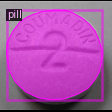

In [7]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pill_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(
     "/content/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("pill_segmentation",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = (
    300
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    32
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 classes (pill)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95   # set the testing threshold for this model
cfg.DATASETS.TEST = ("pill_segmentation", )
predictor = DefaultPredictor(cfg)

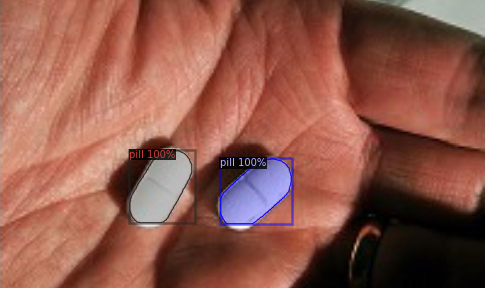

In [32]:
from detectron2.utils.visualizer import ColorMode
im = cv2.imread('/content/data/1.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=pill_metadata, 
                scale=0.5, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])